# **PROJECT 1 : GROUP 6(MA YINCHU)**
# JAPAN 

## **DELIVERABLES**


In [2]:
%pip install wbdata
%pip install pandas-datareader

import numpy as np
import pandas as pd
import wbdata
from pandas_datareader import wb
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Key '-245173633628676742' not in persistent cache.
Key '-3746804110303180049' not in persistent cache.
Key '6538552786766476395' not in persistent cache.
Key '6701884268633273665' not in persistent cache.
Key '3011593012679503839' not in persistent cache.
Key '-5839517701858928722' not in persistent cache.
Key '-6804233617974328143' not in persistent cache.
Key '858955867008598291' not in persistent cache.
Key '-3285164103426443874' not in persistent cache.
Key '-7651915083461187551' not in persistent cache.
Key '3961347752217931134' not in persistent cache.
Key '6678607295318847514' not in persistent cache.
Key '-4558776007889050007' not in persistent cache.
Key '-8249067263842819833' not in persistent cache.
Key '-8085735781976022563' not in persistent cache.
Key '-5406457473375909415' not in persistent cache.
Key '7441318477816609602' not in persistent cache.
Key '1292016095491617598' not in persistent cache.
Key '3914358703729637046' not in persistent cache.
Key '481108561003950186

## 1. [A] Population Statistics 

In this section, we define our population function. It first uses helper functions to retrieve population data from the World Bank API for specific countries, years,age groups, and genders. Since the World Bank reports population data in a 5 year age range, our function calculates population for custom age ranges by determining how much of each 5 year bin overlaps with the user input and divide. It also handles the 80+ age group sepreately and combines male and female population count for aged people 12-30 in 2004 Japan.

In [3]:
import requests
import re

WB_BASE = "https://api.worldbank.org/v2"


class PopulationDataError(ValueError):
    pass


def _wb_get_value(place, indicator, year):
    place = place.strip().upper()
    indicator = indicator.strip()
    year = int(year)

    url = f"{WB_BASE}/country/{place}/indicator/{indicator}"
    params = {"format": "json", "date": str(year), "per_page": 20000}

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()

    if not isinstance(data, list) or len(data) < 2 or not data[1]:
        return None

    val = data[1][0].get("value", None)
    return None if val is None else float(val)


def _age_group_indicator(low, high, sex):
    suffix = "MA" if sex == "males" else "FE"
    return f"SP.POP.{low:02d}{high:02d}.{suffix}"


def _age_80_plus_indicator(sex):
    return "SP.POP.80UP.MA" if sex == "males" else "SP.POP.80UP.FE"


def population(year, sex, age_range, place):
    """
    Returns the population count needed to answer:

    In [year] how many [people/males/females] aged [low] to [high]
    were living in [the world/region/country]?
    """
    if not isinstance(year, int):
        raise PopulationDataError("year must be an int")

    if not isinstance(age_range, tuple) or len(age_range) != 2:
        raise PopulationDataError("age_range must be (low, high)")

    low, high = age_range
    if not (isinstance(low, int) and isinstance(high, int)):
        raise PopulationDataError("age_range values must be ints")

    if low < 0 or high < 0 or high < low:
        raise PopulationDataError("age_range must satisfy 0 <= low <= high")

    sex = sex.strip().lower()
    if sex not in ("people", "males", "females"):
        raise PopulationDataError("sex must be 'people', 'males', or 'females'")

    place = place.strip().upper()
    if not place:
        raise PopulationDataError("place must be a World Bank code like 'JPN' or 'WLD'")

    def one_sex_total(one_sex):
        total = 0.0

        if high >= 80:
            if low > 80:
                raise PopulationDataError("low > 80 not supported (80+ is a single bin)")
            ind80 = _age_80_plus_indicator(one_sex)
            v80 = _wb_get_value(place, ind80, year)
            if v80 is None:
                raise PopulationDataError(f"missing data: {place}, {year}, {ind80}")
            total += v80
            high_effective = 79
        else:
            high_effective = high

        for start in range(0, 80, 5):
            end = start + 4

            overlap_low = max(low, start)
            overlap_high = min(high_effective, end)
            if overlap_low > overlap_high:
                continue

            ind = _age_group_indicator(start, end, one_sex)
            bin_value = _wb_get_value(place, ind, year)
            if bin_value is None:
                raise PopulationDataError(f"missing data: {place}, {year}, {ind}")

            years_covered = overlap_high - overlap_low + 1
            total += bin_value * (years_covered / 5.0)

        return total

    if sex == "people":
        total_value = one_sex_total("males") + one_sex_total("females")
    else:
        total_value = one_sex_total(sex)

    return int(round(total_value))


PLACE_MAP = {
    "japan": "JPN",
    "world": "WLD",
}


def population_from_query(query):
    """
    Takes a query of the form:

    In [year] how many [people/males/females] aged [low] to [high]
    were living in [the world/region/country]?

    and returns the population count.
    """
    parts = re.findall(r"\[(.*?)\]", query, flags=re.DOTALL)

    if len(parts) != 5:
        raise ValueError(
            "Query must have 5 bracketed fields: [year], [sex], [low], [high], [place]"
        )

    year = int(parts[0].strip())
    sex = parts[1].strip().lower()
    low = int(parts[2].strip())
    high = int(parts[3].strip())

    place_raw = parts[4].strip().lower()
    place_raw = re.sub(r"\s+", " ", place_raw)

    if place_raw in PLACE_MAP:
        place = PLACE_MAP[place_raw]
    else:
        place = place_raw.upper()

    return population(year, sex, (low, high), place)
def ask(query):
    print(population_from_query(query))

In [4]:
ask("In [2004] how many [people] aged [12] to [30] were living in [Japan]?")

28319362


## 2.[A] Unit Tests

This section of Unit Testing verifies that all of our deliverable functions work properly.

In [5]:
def run_tests():
    jp_2004 = population(2004, "people", (0, 79), "JPN")
    assert jp_2004 > 50_000_000, "Japan 2004 (0-79) should be > 50M"

    wld_2004 = population(2004, "people", (0, 79), "WLD")
    assert wld_2004 > 5_000_000_000, "World 2004 (0-79) should be > 5B"

    year = 2004
    place = "JPN"
    ages = (12, 30)
    m = population(year, "males", ages, place)
    f = population(year, "females", ages, place)
    p = population(year, "people", ages, place)
    assert abs((m + f) - p) <= 5, "people should equal males+females (rounding tolerance)"

    small = population(2004, "people", (12, 20), "JPN")
    big = population(2004, "people", (12, 30), "JPN")
    assert big >= small, "Expanding age range should not decrease population"

    clean = population(2004, "people", (12, 30), "JPN")
    messy = population(2004, "people", (12, 30), "  jpn  ")
    assert clean == messy, "Place code should be case/whitespace insensitive"

    q = "In [2004] how many [people] aged [12] to [30] were living in [Japan]?"
    parsed = population_from_query(q)
    direct = population(2004, "people", (12, 30), "JPN")
    assert parsed == direct, "Query parser should match direct function call"

    try:
        population(2004, "men", (12, 30), "JPN")
        assert False, "Expected error for invalid sex"
    except Exception:
        pass

    try:
        population(2004, "people", (30, 12), "JPN")
        assert False, "Expected error for reversed age_range"
    except Exception:
        pass

    a = population(2004, "people", (80, 80), "JPN")   # 80+ bin
    b = population(2004, "people", (0, 80), "JPN")    # includes 80+
    assert b >= a, "(0,80) should be >= (80,80)"

    print("All tests passed!")

# 3.[A] Population DataFrames

In [6]:
## creating age bins

age_ranges = []

for i in np.arange(0, 80, 5):
    age_ranges.append({'code': f"{i:02d}{i + 4:02d}", 
                       'label': f"{i} - {i + 4}"
                      })
    
age_ranges.append({'code': '80UP', 
                   'label': '80+'})
print(age_ranges)

[{'code': '0004', 'label': '0 - 4'}, {'code': '0509', 'label': '5 - 9'}, {'code': '1014', 'label': '10 - 14'}, {'code': '1519', 'label': '15 - 19'}, {'code': '2024', 'label': '20 - 24'}, {'code': '2529', 'label': '25 - 29'}, {'code': '3034', 'label': '30 - 34'}, {'code': '3539', 'label': '35 - 39'}, {'code': '4044', 'label': '40 - 44'}, {'code': '4549', 'label': '45 - 49'}, {'code': '5054', 'label': '50 - 54'}, {'code': '5559', 'label': '55 - 59'}, {'code': '6064', 'label': '60 - 64'}, {'code': '6569', 'label': '65 - 69'}, {'code': '7074', 'label': '70 - 74'}, {'code': '7579', 'label': '75 - 79'}, {'code': '80UP', 'label': '80+'}]


In [7]:
## separating by sex

male_variables = {f"SP.POP.{b['code']}.MA": f"Males {b['label']}" for b in age_ranges}
female_variables = {f"SP.POP.{b['code']}.FE": f"Females {b['label']}" for b in age_ranges}

variables = {}

variables.update(male_variables)
variables.update(female_variables)

print(variables)

{'SP.POP.0004.MA': 'Males 0 - 4', 'SP.POP.0509.MA': 'Males 5 - 9', 'SP.POP.1014.MA': 'Males 10 - 14', 'SP.POP.1519.MA': 'Males 15 - 19', 'SP.POP.2024.MA': 'Males 20 - 24', 'SP.POP.2529.MA': 'Males 25 - 29', 'SP.POP.3034.MA': 'Males 30 - 34', 'SP.POP.3539.MA': 'Males 35 - 39', 'SP.POP.4044.MA': 'Males 40 - 44', 'SP.POP.4549.MA': 'Males 45 - 49', 'SP.POP.5054.MA': 'Males 50 - 54', 'SP.POP.5559.MA': 'Males 55 - 59', 'SP.POP.6064.MA': 'Males 60 - 64', 'SP.POP.6569.MA': 'Males 65 - 69', 'SP.POP.7074.MA': 'Males 70 - 74', 'SP.POP.7579.MA': 'Males 75 - 79', 'SP.POP.80UP.MA': 'Males 80+', 'SP.POP.0004.FE': 'Females 0 - 4', 'SP.POP.0509.FE': 'Females 5 - 9', 'SP.POP.1014.FE': 'Females 10 - 14', 'SP.POP.1519.FE': 'Females 15 - 19', 'SP.POP.2024.FE': 'Females 20 - 24', 'SP.POP.2529.FE': 'Females 25 - 29', 'SP.POP.3034.FE': 'Females 30 - 34', 'SP.POP.3539.FE': 'Females 35 - 39', 'SP.POP.4044.FE': 'Females 40 - 44', 'SP.POP.4549.FE': 'Females 45 - 49', 'SP.POP.5054.FE': 'Females 50 - 54', 'SP.POP.5

In [8]:
## dataframe function

def population_df(countries, start, end):
    
    df = wb.download(indicator = variables, 
                     country = countries, 
                     start = start, 
                     end = end)
    
    df = df.rename(columns = variables)
    
    df = df.sort_index()
    
    return df

pop = population_df(['JPN'], start = 1960, end = 2020)
pop.head()

/tmp/ipykernel_612/1979740262.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(indicator = variables,


Males 0 - 4  Males 5 - 9  Males 10 - 14  Males 15 - 19  \
country year                                                           
Japan   1960      3950052      4542518        5544049        4513649   
        1961      3912426      4313624        5617745        4495425   
        1962      3925139      4115762        5401253        4715280   
        1963      3953874      3982746        5095235        4967061   
        1964      3981167      3930559        4791482        5225864   

              Males 20 - 24  Males 25 - 29  Males 30 - 34  Males 35 - 39  \
country year                                                               
Japan   1960        4163519        4139548        3758394        2817147   
        1961        4251205        4175733        3852253        3052832   
        1962        4367172        4178136        3943082        3278211   
        1963        4535534        4141126        4020242        3472660   
        1964        4604600        4130500        4085247        3622470   

              Males 40 - 44  Males 45 - 49  ...  Females 35 - 39  \
country year                                ...                    
Japan   1960        2223852        2191049  ...          3328103   
        1961        2245801        2191509  ...          3441145   
        1962        2308578        2177279  ...          3536659   
        1963        2434766        2147045  ...          3628097   
        1964        2593939        2146223  ...          3705035   

              Females 40 - 44  Females 45 - 49  Females 50 - 54  \
country year                                                      
Japan   1960          2764957          2565014          2201774   
        1961          2841671          2589085          2290916   
        1962          2947409          2597731          2351532   
        1963          3079521          2590495          2405105   
        1964          3184362          2628681          2450799   

              Females 55 - 59  Females 60 - 64  Females 65 - 69  \
country year                                                      
Japan   1960          1837383          1526588          1150389   
        1961          1850170          1587351          1190893   
        1962          1890588          1639945          1236254   
        1963          1955447          1679904          1283462   
        1964          2031048          1710864          1323913   

              Females 70 - 74  Females 75 - 79  Females 80+  
country year                                                 
Japan   1960           882378           576206       459259  
        1961           899199           580355       473218  
        1962           910953           592421       483289  
        1963           918174           612187       495155  
        1964           935270           636418       509097  

[5 rows x 34 columns]

# 4.[B]Population Pyramids

In [9]:
def _age_sort_key(label):
    s = str(label)
    num = ''
    for character in s:
        if character.isdigit():
            num += character
        elif num:
            break
    return int(num) if num else 9999

def population_pyramid(df, country = None, year = None, title = None, ax = None):
    if country is not None and year is not None:
        row = df.loc[(country, str(year))]
    else:
        row = df.iloc[0]

    male_cols = [c for c in row.index if str(c).startswith('Males ')]
    female_cols = [c for c in row.index if str(c).startswith('Females ')]

    if len(male_cols) == 0 or len(female_cols) == 0:
        raise ValueError('No columns starting with Males and Females')

    def age_label(column_name, prefix):
        return str(column_name)[len(prefix):]

    male_map = {age_label(c, 'Males '): c for c in male_cols}
    female_map = {age_label(c, 'Females '): c for c in female_cols}

    ages = sorted(set(male_map.keys()) & set(female_map.keys()), key = _age_sort_key)

    males = np.array([row[male_map[a]] if a in male_map else np.nan for a in ages], dtype=float)
    females = np.array([row[female_map[a]] if a in female_map else np.nan for a in ages], dtype=float)

    scale = 1e6
    males = males/scale
    females = females/scale

    males_plot = -males
    females_plot = females

    if ax is None:
        fig, ax = plt.subplots(figsize = (7, 6))

    y = np.arange(len(ages))
    ax.barh(y, males_plot, label = "Males")
    ax.barh(y, females_plot, label = "Females")

    ax.set_yticks(y)
    ax.set_yticklabels(ages)

    max_val = max(np.nanmax(males_plot), np.nanmax(females_plot)) if len(ages) else 1
    ax.set_xlim(-max_val * 1.1, max_val * 1.1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{abs(int(x))}"))

    ax.axvline(0, linewidth=1)

    ax.set_xlabel("Population (millions)")
    ax.set_ylabel("Age group")

    if title is None:
        if country is not None:
            title = f"{country} Population Pyramid"
        else:
            title = "Population Pyramid"
    ax.set_title(title)

    ax.legend()
    return ax

<Axes: title={'center': 'Japan Population Pyramid'}, xlabel='Population (millions)', ylabel='Age group'>

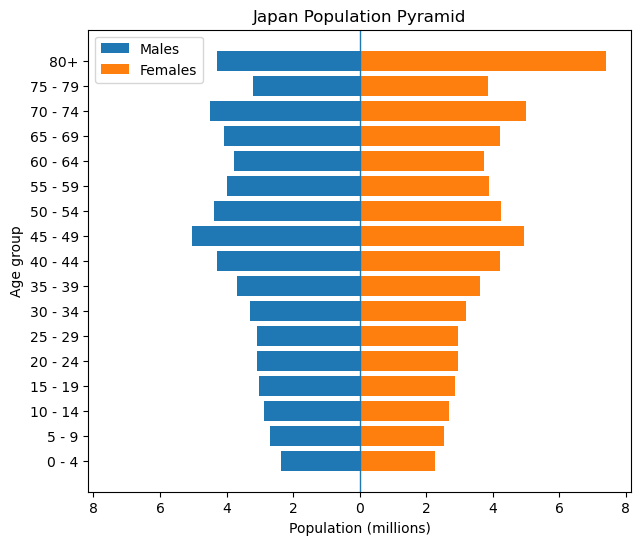

In [10]:
population_pyramid(pop, country = 'Japan', year = 2020)

In [11]:
def animated_population_pyramid(df, country, years = None, interval = 400, title = None):

    fig, ax = plt.subplots(figsize=(7, 6))

    available_years = list(df.loc[country].index)
    if years is None:
        years = available_years
    else:
        years = [str(y) for y in years]
        years = [y for y in years if y in available_years]

    if len(years) == 0:
        raise ValueError("No matching years found for that country in the dataframe.")

    male_cols = [c for c in df.columns if str(c).startswith("Males ")]
    female_cols = [c for c in df.columns if str(c).startswith("Females ")]
    scale = 1e6  # millions (matches your pyramid)
    max_val = (df.loc[country, male_cols + female_cols].max().max()) / scale
    xlim = (-max_val * 1.1, max_val * 1.1)

    def update(frame_year):
        ax.clear()

        population_pyramid(
            df,
            country=country,
            year=frame_year,
            title=(title if title is not None else f"{country} Population Pyramid ({frame_year})"),
            ax=ax
        )

        ax.set_xlim(*xlim)
        return ax

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=years,
        interval=interval,
        blit=False,
        repeat=True
    )

    plt.close(fig)
    return HTML(anim.to_jshtml())

In [12]:
animated_population_pyramid(pop, country = "Japan", interval = 500)

# 7. [C] Other Visualization Tools

### Graphing WB Data

In [13]:
def plot_wdi_indicator(countries, indicator_code, start=1960, end=2023,
                       title=None, ylabel=None):

    df = wb.download(
        indicator=indicator_code,
        country=countries,
        start=start,
        end=end
    ).reset_index()

    df["year"] = df["year"].astype(int)
    df = df.sort_values("year")

    if title is None:
        title = f"{indicator_code} Over Time"
    if ylabel is None:
        ylabel = indicator_code

    fig, ax = plt.subplots(figsize=(8,5))

    for name, country_data in df.groupby("country"):
        ax.plot(country_data["year"],
                country_data[indicator_code],
                label=name)

    ax.set_xlabel("Year")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)

    return df

### Aging Population

In [14]:
def plot_aging(countries, start=1960, end=2023):
    return plot_wdi_indicator(
        countries=countries,
        indicator_code="SP.POP.65UP.TO.ZS",
        start=start,
        end=end,
        title="Population Ages 65+ (% of Total)",
        ylabel="Percent of Population"
    )

/tmp/ipykernel_612/649397192.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(


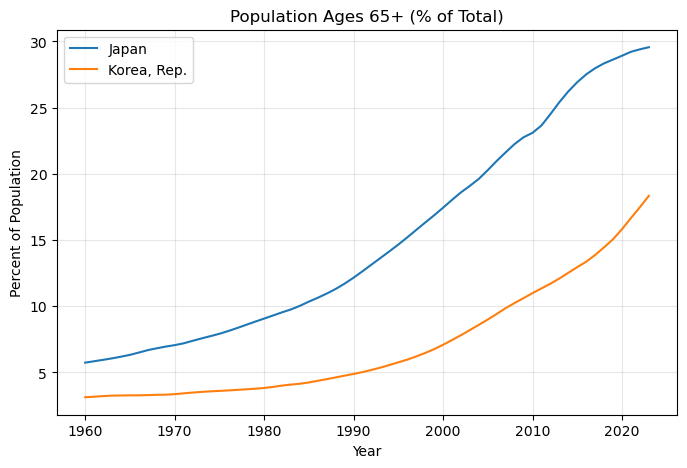

In [15]:
plot_aging(["JPN", "KOR"], start=1960, end=2023)
plt.show()

### Fertility Rate

In [16]:
def plot_fertility(countries, start=1960, end=2023):
    return plot_wdi_indicator(
        countries=countries,
        indicator_code="SP.DYN.TFRT.IN",
        start=start,
        end=end,
        title="Total Fertility Rate (births per woman)",
        ylabel="Births per woman"
    )

/tmp/ipykernel_612/649397192.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(


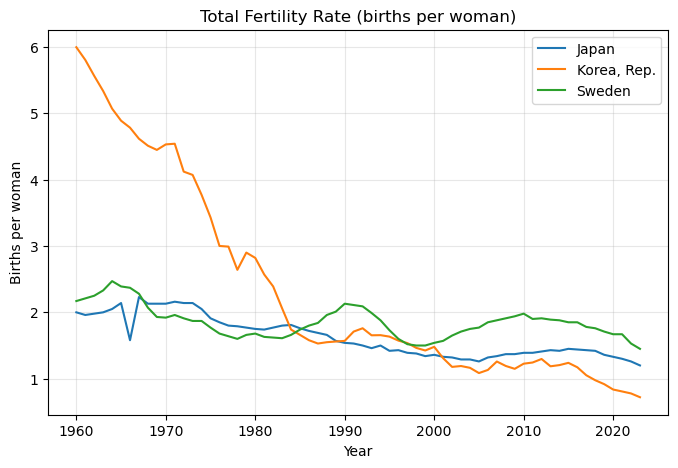

In [17]:
plot_fertility(["JPN", "KOR", "SWE"], start=1960, end=2023)
plt.show()

### Female Labor Force Participation

In [18]:
def plot_female_labor(countries, start=1960, end=2023):
    return plot_wdi_indicator(
        countries=countries,
        indicator_code="SL.TLF.CACT.FE.ZS",
        start=start,
        end=end,
        title="Female Labor Force Participation (%)",
        ylabel="Percent of Female Population 15+"
    )

/tmp/ipykernel_612/649397192.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(


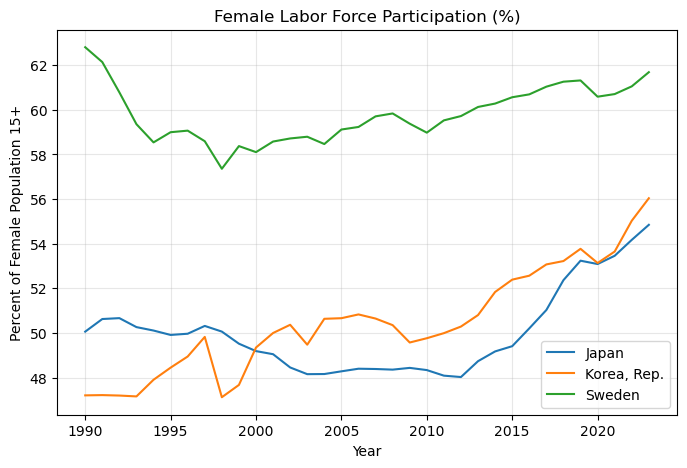

In [19]:
plot_female_labor(["JPN", "KOR", "SWE"], start=1960, end=2023)
plt.show()

### Migration Trends

In [20]:
def plot_net_migration(countries, start=1960, end=2023):
    return plot_wdi_indicator(
        countries=countries,
        indicator_code="SM.POP.NETM",
        start=start,
        end=end,
        title="Net Migration (net number of migrants)",
        ylabel="Net migrants"
    )

/tmp/ipykernel_612/649397192.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = wb.download(


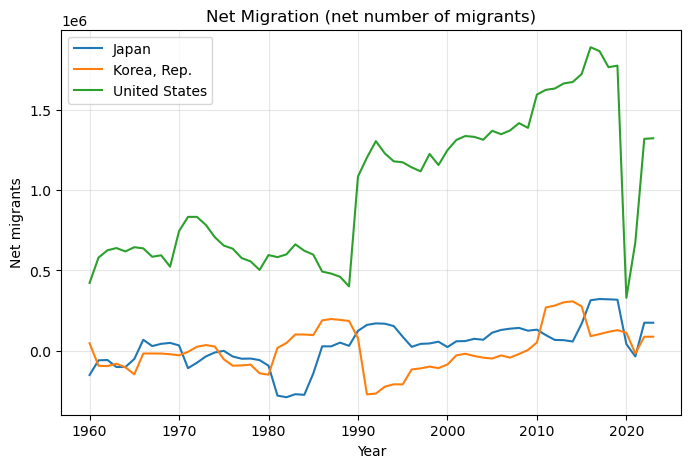

In [21]:
plot_net_migration(["JPN", "KOR", "USA"], start=1960, end=2023)
plt.show()